## To do list:

* Test the model by predicting CO2 at a whole site and depth
* Run model without soil moisture or bulk EC (this will add Shale Hills data to the model)
* There is a very strange error in the code where the depth column in df_out can't be accessed via slicing with ==, but it can be accessed by slicing with >= or <=. When I first made the code it ran fine, but upon restarting I can't get the == slicing to work. I APPEAR TO HAVE FIXED THIS PROBLEM BY GETTING DEPTH A DIFFERENT WAY, BUT I STILL DON'T KNOW WHY IT DIDN'T WORK IN THE FIRST PLACE
* Statistics on missing values
    - Excel file in metadata titled "missing_value_stats"
    - Currently only have stats for CO2 at 30cm. If we want to interpolate, we will need statistics for all depths.
    
## Quality Control: All listed items have been completed
* Total counts before removal match with processed csv files from each notebook
* Site counts times unique depths matches merged df before dropping nan records
* Total records after removal match total records minus the number of nan records for CO2 in total records
* Random records from each pit match each processed csv file
* Predicted values of CO2 should be calculated only from mean and std of the training data, not all the data
    - Training and testing data should be standardized separately
* df_out 'index' column matches the original df.iloc index


## Possible ways to improve model performance:

* Add atmospheric CO2
* Apply your better spike removal code to the other sites
* Try the interpolated precip from PRISM
* Try random forest model
* Interpolate missing CO2 and soil moisture (try single site interpolation)
* Try neural net model
* Use latitude instead of site number
* Add elevation
* Add land cover type (maybe we should try biomass carbon density maps instead)



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive 
# list of all potential features across all pits
features = ['CO2', 'timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 
            'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site', 'Season']
m = len(features)

# Define site and pit number indices
site_nos = {'Calhoun': 0, 'Shale_Hills': 1, 
            'Catalina-Jemez': 2, 'Seca_Floresta': 3}
pit_nos = {}
i = 0
for site, pits in all_pits.items():
    for pit in pits:
        pit_nos[pit] = i
        i += 1
        
# Remove pits with manual samples
del all_pits['Seca_Floresta']
all_pits['Calhoun'].remove('R1C2')
all_pits['Shale_Hills'].remove('SPMS')

In [15]:
total_count = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        with open(infile) as f:
            for i, l in enumerate(f):
                pass
        nlines = i + 1
        total_count += nlines
        print(site, pit, '--', nlines)
print(total_count)

Calhoun R1C1 -- 28388
Calhoun R1H1 -- 28394
Calhoun R1P1 -- 28393
Catalina-Jemez BGZOB1 -- 27277
Catalina-Jemez BGZOB2 -- 27302
Catalina-Jemez BGZOB3 -- 27297
Catalina-Jemez BGZOB4 -- 27275
Catalina-Jemez Green1 -- 27976
Catalina-Jemez Green2 -- 6995
Catalina-Jemez Green3 -- 27975
Catalina-Jemez MC1 -- 72374
Catalina-Jemez MC2 -- 72658
Catalina-Jemez MC3 -- 72539
Catalina-Jemez MC4 -- 72540
Catalina-Jemez MC5 -- 71698
Catalina-Jemez MC6 -- 72539
Shale_Hills LRMS -- 14137
Shale_Hills NPMS -- 34448
Shale_Hills SPVF -- 2999
Shale_Hills TMMS -- 35403
778607


In [16]:
before_dropping=28387*2+28393*2+28392*2+27276*3+27301*4+27296*4+27274*4+27975*4+6994*4+27974*4+72373*4+72657*4+72538*4+72539*4+71697*4+72538*4+14136*2+34447*1+2998*2+35402*1
print (before_dropping)

#after_dropping=
#print (after_dropping)

2672913


In [17]:
# Load in and merge all files
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        df = pd.read_csv(infile, parse_dates=[0], na_values=[-99999])

        # Remove records without any CO2 data
        co2_cols = [col for col in df.columns if 'CO2' in col]
        df = df[~df.loc[:, co2_cols].isna().all(axis=1)]
        
        depths = []
        for col in df.columns:
            if ('precip' not in col) and ('DateTime' not in col):
                depths.append(col.split('_')[1].split('cm')[0])
        unique_depths = list(set(depths))

        # t is the number of time steps
        t = df.shape[0]

        # data shape is the # of observations (# time points * depths), # features
        cur_data = np.empty((t*len(unique_depths), m))
        cur_data[:] = np.nan

        for i, depth in enumerate(unique_depths):
            depth_cols = [col for col in df.columns if '_%scm' % depth in col]
            for j, feature in enumerate(features):
                # Look for columns with this feature and depth in the name
                if feature == 'precip':
                    col = 'PRISM_precip.mm'
                elif feature == 'timestamp':
                    col = [col for col in df.columns if 'DateTime' in col]
                    col = col[0]
                elif feature == 'Season':
                    col = [col for col in df.columns if 'DateTime' in col]
                    df['quarter'] = df[col[0]].dt.quarter
                    col = 'quarter'
                else:
                    matches = [col for col in depth_cols if feature in col]

                    # Correct for fact that "O2" search returns "CO2" as well
                    if feature == 'O2':
                        matches = [col for col in matches if 'CO2' not in col]

                    if len(matches) > 1:
                        raise ValueError("""More than one possible match found for 
                        %s %s %scm %s""" %(site, pit, depth, feature))
                    elif len(matches) == 1:
                        col = matches[0]
                    else:
                        col = ""
                        continue
    
                # Now that we have the column name, add this subset to cur_data
                cur_data[i*t:(i+1)*t, j] = df[col].values

            # Add in depth
            cur_data[i*t:(i+1)*t, features.index('Depth')] = depth
        
        # Add in pit and site indices
        cur_data[:, features.index('Pit')] = pit_nos[pit]
        cur_data[:, features.index('Site')] = site_nos[site]
        
        # Copy current data to dict of all data
        data[pit] = cur_data.copy()

In [18]:
# Merge all data into a single numpy array
for i, (pit, array) in enumerate(data.items()):
    if i == 0:
        merged = array.copy()
    else:
        merged = np.append(merged, array, axis=0)

# Remove rows without any CO2 data
all_rows, _ = merged.shape
merged = merged[~np.isnan(merged[:, 0]), :]
trimmed = all_rows - merged.shape[0]
print(f'Removed {trimmed:,} rows without CO2 data')

df = pd.DataFrame(data=merged, columns=features)

Removed 115,759 rows without CO2 data


In [19]:
df
#df[df.Pit==0]

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,WaterPotential,ReductionPotential,Pit,Depth,Site,Season
0,7495.0000,1.459379e+18,NaN,NaN,NaN,15.99,18.988224,NaN,NaN,0.0,150.0,0.0,1.0
1,7715.0000,1.459382e+18,0.0,NaN,NaN,15.99,18.761198,NaN,NaN,0.0,150.0,0.0,1.0
2,7910.0000,1.459386e+18,0.0,NaN,NaN,15.99,18.761198,NaN,NaN,0.0,150.0,0.0,1.0
3,7875.0000,1.459390e+18,0.0,NaN,NaN,15.99,18.761198,NaN,NaN,0.0,150.0,0.0,1.0
4,8325.0000,1.459393e+18,0.0,NaN,NaN,15.99,18.587071,NaN,NaN,0.0,150.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457156,3683.5210,1.561374e+18,NaN,NaN,NaN,14.36,16.650000,NaN,NaN,22.0,30.0,1.0,2.0
1457157,3864.7151,1.561378e+18,NaN,NaN,NaN,14.34,16.639999,NaN,NaN,22.0,30.0,1.0,2.0
1457158,4066.6121,1.561381e+18,NaN,NaN,NaN,14.33,16.629999,NaN,NaN,22.0,30.0,1.0,2.0
1457159,4009.4121,1.561385e+18,NaN,NaN,NaN,14.31,16.629999,NaN,NaN,22.0,30.0,1.0,2.0


In [13]:
nan_index=df['CO2'][df['CO2'].notna()==False]
len(nan_index)

2672913-len(nan_index)

1457161

In [4]:
outfile = '../../merged_processed_data/MergeProcessedData.csv'
np.savetxt(outfile, merged, fmt='%.4f', delimiter=",")


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
# This cell imputes missing values using nearest neighbors, and I can get it to run 
# fine for 100,000 records, but I can't get the code to run for the full 1.4m records.
# I am thinking we should try to parallelize to get this to work for the full dataset.

df.drop(columns=['WaterPotential', 'ReductionPotential', 'Pit', 'Site', 'Season', 'timestamp'], inplace=True)

df
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights='uniform', metric='nan_euclidean')
df=imputer.fit_transform(df)

In [20]:
from sklearn.preprocessing import StandardScaler

df.drop(columns=['WaterPotential', 'ReductionPotential'], 
        inplace=True)

df=df.dropna()
df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
6794,13570.00000,1.459382e+18,0.0,0.358000,0.044000,16.70500,19.413019,0.0,50.0,0.0,1.0
6795,13830.00000,1.459386e+18,0.0,0.358000,0.044000,16.77000,19.417373,0.0,50.0,0.0,1.0
6796,14100.00000,1.459390e+18,0.0,0.358000,0.044000,16.83500,19.421726,0.0,50.0,0.0,1.0
6797,14315.00000,1.459393e+18,0.0,0.358000,0.044000,16.89000,19.425410,0.0,50.0,0.0,1.0
6798,14515.00000,1.459397e+18,0.0,0.358000,0.044000,16.94000,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1393070,625.05675,1.514664e+18,0.0,0.098000,0.008333,0.70850,13.778000,16.0,10.0,2.0,4.0
1393071,620.41800,1.514668e+18,0.0,0.098000,0.010000,0.68825,13.777750,16.0,10.0,2.0,4.0
1393072,611.34600,1.514671e+18,0.0,0.098000,0.010000,0.63875,13.780500,16.0,10.0,2.0,4.0
1393073,607.84425,1.514675e+18,0.0,0.098000,0.010000,0.60550,13.774000,16.0,10.0,2.0,4.0


In [22]:
print(np.unique(df['Depth'].values))

[ 10.  30.  50.  60.  80. 100.]


In [23]:
#Drop the numerically arbitrary columns when doing PCA, but don't drop for machine learning model (they will be dropped later on)


df['new_index']=list(range(0, len(df)))
df_reindex=df.set_index('new_index')
df=df.drop(columns='new_index')
#df_reindex=df_reindex.drop(columns=['Site', 'Pit', 'Season', 'timestamp'])

df_st =  StandardScaler().fit_transform(df_reindex) 
df_st1=pd.DataFrame(data=df_st)
df_st1

,0,1,2,3,4,5,6,7,8,9,10
0,2.326368,-0.054230,-0.366206,1.892727,0.162984,1.426459,0.773260,-2.166861,0.432495,-5.498728,-1.405168
1,2.393383,-0.054134,-0.366206,1.892727,0.162984,1.438441,0.774392,-2.166861,0.432495,-5.498728,-1.405168
2,2.462976,-0.054039,-0.366206,1.892727,0.162984,1.450422,0.775524,-2.166861,0.432495,-5.498728,-1.405168
3,2.518393,-0.053944,-0.366206,1.892727,0.162984,1.460560,0.776482,-2.166861,0.432495,-5.498728,-1.405168
4,2.569944,-0.053848,-0.366206,1.892727,0.162984,1.469777,0.777353,-2.166861,0.432495,-5.498728,-1.405168
...,...,...,...,...,...,...,...,...,...,...,...
837495,-1.010219,1.411195,-0.366206,-1.033831,-0.679847,-1.522163,-0.692086,1.775900,-1.106148,0.181860,1.297692
837496,-1.011414,1.411290,-0.366206,-1.033831,-0.640462,-1.525895,-0.692151,1.775900,-1.106148,0.181860,1.297692
837497,-1.013753,1.411386,-0.366206,-1.033831,-0.640462,-1.535020,-0.691436,1.775900,-1.106148,0.181860,1.297692
837498,-1.014655,1.411481,-0.366206,-1.033831,-0.640462,-1.541149,-0.693126,1.775900,-1.106148,0.181860,1.297692


In [10]:
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
df_st_transform
df_st=df_st[df_st_transform[:,0]<=14]
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
len(df_st[:,0])

837494

In [11]:

pca.explained_variance_ratio_


array([0.28405118, 0.22108901, 0.14464826, 0.12069703, 0.08463448,
       0.0807914 , 0.06408863])

In [12]:
pca_out=pca
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_reindex.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
CO2,0.241354,0.619684,-0.031393,0.165358,-0.423012,0.282339,0.520343
precip,0.125367,0.164747,0.871713,-0.432744,0.098795,0.011568,0.009800
SoilMoisture,0.575072,-0.037753,-0.032966,-0.056638,-0.551306,-0.123804,-0.586776
BulkEC,0.483864,-0.153441,0.066978,0.335544,0.457918,0.634105,-0.116093
Temp,-0.081720,0.625856,0.094184,0.459464,0.321539,-0.344597,-0.399393
O2,-0.538792,0.210973,-0.023238,-0.164380,-0.210246,0.619664,-0.457653
Depth,0.253424,0.357317,-0.473442,-0.656859,0.387406,0.001939,-0.049015


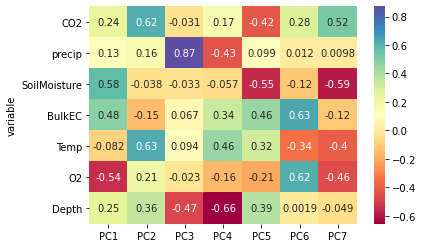

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

<Figure size 432x288 with 0 Axes>

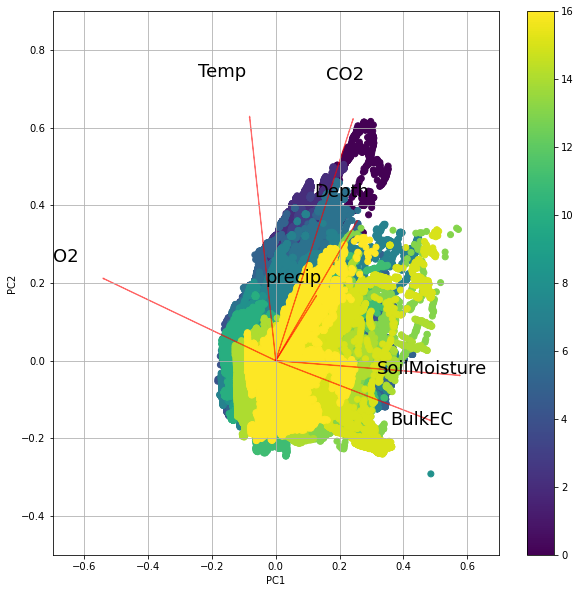

In [14]:
#PCA colored by pit

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig=plt.gcf()
    plt.figure(figsize=(10,10))
    plt.scatter(xs * scalex,ys * scaley, c = df.Pit[0:len(df_st)])#df_st[:,6])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df_reindex.columns.values[i], color = 'k', ha = 'right', va = 'bottom', fontsize=18)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

<Figure size 432x288 with 0 Axes>

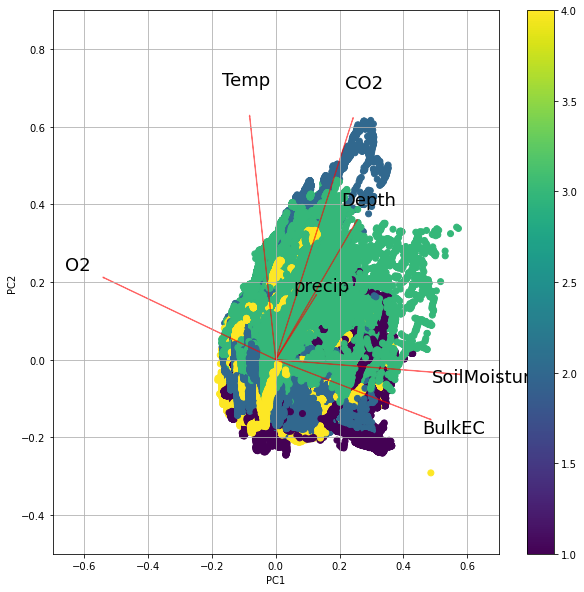

In [15]:
#PCA colored by site

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig=plt.gcf()
    plt.figure(figsize=(10,10))
    plt.scatter(xs * scalex,ys * scaley, c = df.Season[0:len(df_st)])#df_st[:,6])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df_reindex.columns.values[i], color = 'k', ha = 'center', va = 'center', fontsize=18)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

<Figure size 432x288 with 0 Axes>

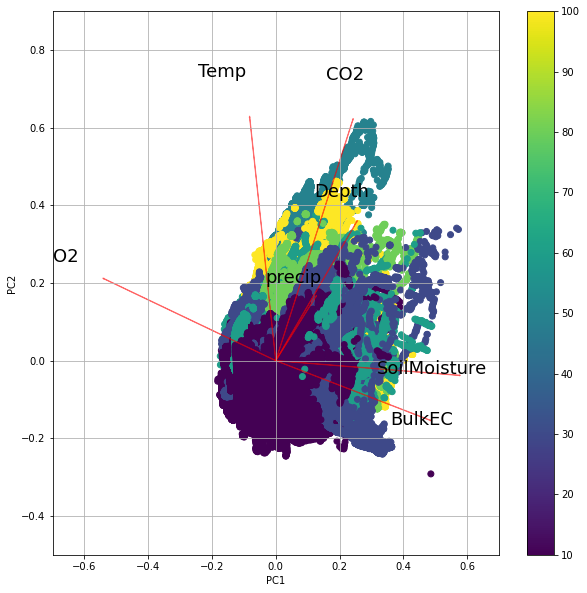

In [16]:
#PCA colored by depth

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig=plt.gcf()
    plt.figure(figsize=(10,10))
    plt.scatter(xs * scalex,ys * scaley, c = df.Depth[0:len(df_st)])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df_reindex.columns.values[i], color = 'k', ha = 'right', va = 'bottom', fontsize=18)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [24]:
#Run this for machine learning model with standardization

from sklearn.model_selection import train_test_split

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
X=df_st1[[ 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",
y=df_st1['CO2']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [56]:
#Run this for machine learning model without standardization

from sklearn.model_selection import train_test_split

df.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Depth', 'Site']
X=df[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2',  'Depth', 'Site']]  # Features\n",
y=df['CO2']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
neigh.score(X_test,y_test)

0.9904539019756289

In [26]:
#X_original=df.iloc[y_train]
prediction=neigh.predict(X_test)
df_pred=pd.DataFrame(data=prediction)
#prediction_original_dataset=neigh.predict(X_original)


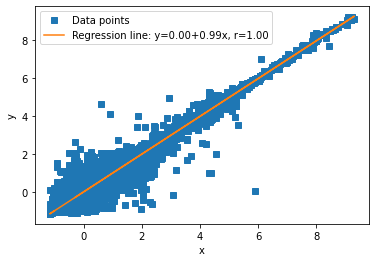

In [11]:
import scipy.stats
x=y_test
y=prediction
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [12]:
result = scipy.stats.linregress(y_test, prediction)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(y_test, prediction))
print(metrics.max_error(y_test, prediction))
print(metrics.mean_absolute_error(y_test, prediction))
print(metrics.mean_squared_error(y_test, prediction, squared=False))




0.995198612953319
0.0
0.9933071902923253
0.00023869615849338502
0.9904118055321401
5.827131122581822
0.03166964263754111
0.0973442849344052


In [13]:
r, p = scipy.stats.pearsonr(y_test, prediction)
print (r)
print (p)

0.9951866610027502
0.0


In [14]:
result = scipy.stats.spearmanr(y_test, prediction)
print (result.correlation)
print (result.pvalue)

0.9907393941575595
0.0


In [15]:

result = scipy.stats.kendalltau(y_test, prediction)
print (result.correlation)
print (result.pvalue)


0.9536105162913762
0.0


In [27]:
prediction_original=prediction*np.std(df['CO2'])+np.mean(df.CO2)
y_test_original=y_test*np.std(df['CO2'])+np.mean(df.CO2)

y_hats=prediction_original
df_out = X_test.reset_index()
df_out["Actual"] = y_test_original.reset_index()['CO2']
df_out["Prediction"] = y_hats#.reset_index()[0]
y_test['preds'] = y_hats
#df_out['Depth']=df_out.Depth*np.std(df['Depth'])+np.mean(df.Depth)
df_out['SoilMoisture']=df_out['SoilMoisture']*np.std(df['SoilMoisture'])+np.mean(df.SoilMoisture)
df_out['precip']=df_out.precip*np.std(df['precip'])+np.mean(df.precip)
df_out['BulkEC']=df_out['BulkEC']*np.std(df['BulkEC'])+np.mean(df.BulkEC)
df_out['O2']=df_out.O2*np.std(df['O2'])+np.mean(df.O2)
df_out['Temp']=df_out.Temp*np.std(df['Temp'])+np.mean(df.Temp)
df_out['Site']=df_reindex.Site.loc[df_out['index']].values
df_out['timestamp']=df_reindex.timestamp.loc[df_out['index']].values
df_out['Pit']=df_reindex.Pit.loc[df_out['index']].values
df_out['Season']=df_reindex.Season.loc[df_out['index']].values
df_out['Depth']=df_reindex.Depth.loc[df_out['index']].values




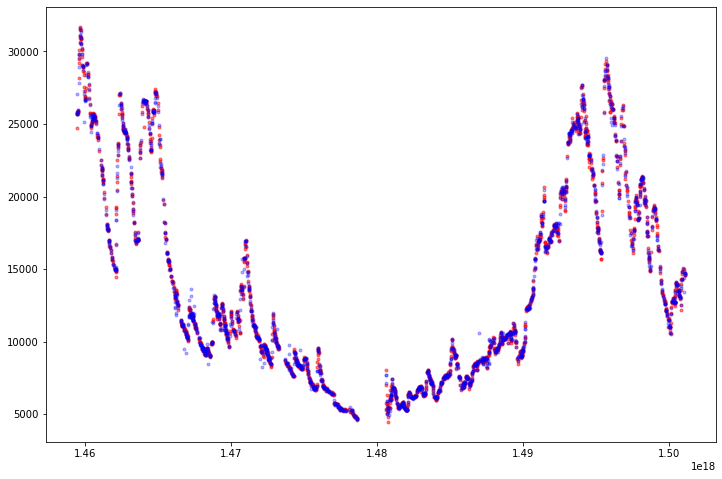

In [28]:
# Red is actual, blue is predicted
# Pit 4 (BGZOB1) is bad at 10cm and 30cm, but not too bad at 60cm. Interestingly, the model predicts the sensor error at 30cm.
# Pit 5 (BGZOB2) is much better than pit 4, but not as good as Calhoun pits. Performance is again best at 60cm.
# Weird model predictions for Pit 7 at 10cm around timestep 1.46
# Pit 9 at 30cm depth has lowest RMSE of 33
PIT=df_out.Pit==2
DEPTH=df_out.Depth==50
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.scatter(df_out.timestamp[PIT][DEPTH], df_out.Actual[PIT][DEPTH], marker='.', alpha=.5, c='r')
ax.scatter(df_out.timestamp[PIT][DEPTH], df_out.Prediction[PIT][DEPTH], marker='.', alpha=.3, c='b')
#df_out.index[df_out.Depth>=30]

In [30]:
df_out[df_out.Pit==5][df_out['Depth']==10]
df_out.index=df_out['index']
df_out

<ipython-input-30-badcb8713966>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_out[df_out.Pit==5][df_out['Depth']==10]


,index,precip,SoilMoisture,BulkEC,Temp,O2,Depth,Actual,Prediction,Site,timestamp,Pit,Season
index,,,,,,,,,,,,,
756358,756358,3.800000e-01,0.221167,1.300000e-01,1.926250,12.511250,30.0,5873.11475,5540.902750,2.0,1.420974e+18,15.0,1.0
655567,655567,7.740000e+00,0.260667,1.950000e-01,15.760548,9.599097,10.0,12254.26500,12436.720000,2.0,1.379506e+18,13.0,3.0
70717,70717,3.093081e-12,0.006000,7.500000e-03,6.162000,20.098000,60.0,2498.27875,2510.983500,2.0,1.481562e+18,4.0,4.0
354322,354322,3.093081e-12,0.171000,3.198830e-15,6.911250,16.156500,60.0,7870.06375,8161.147875,2.0,1.457273e+18,7.0,1.0
205706,205706,3.093081e-12,0.134000,5.000000e-03,10.987250,17.331000,10.0,1971.02950,1826.834000,2.0,1.494788e+18,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177650,177650,3.093081e-12,0.256750,4.000000e-02,3.666000,5.565500,60.0,1740.35875,1795.919375,2.0,1.489061e+18,5.0,1.0
214949,214949,3.093081e-12,0.291500,2.250000e-02,8.927250,19.471000,100.0,2218.00925,2224.240125,2.0,1.431432e+18,6.0,2.0
172763,172763,3.093081e-12,0.225000,4.750000e-02,14.176500,14.886750,60.0,2385.18000,2368.393000,2.0,1.471468e+18,5.0,3.0


In [32]:
df.iloc[177650:177651]

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
229007,1740.35875,1.489061e+18,0.0,0.25675,0.04,3.666,5.5655,5.0,60.0,2.0,1.0


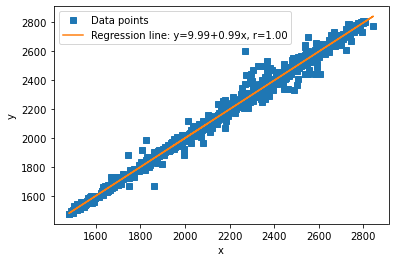

In [70]:
PIT=df_out.Pit==9
DEPTH=df_out.Depth==30
x=df_out.Actual[DEPTH][PIT]
y=df_out.Prediction[DEPTH][PIT]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [69]:

PIT=df_out.Pit==9
DEPTH=df_out.Depth==30
x=df_out.Actual[PIT][DEPTH]
y=df_out.Prediction[PIT][DEPTH]
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))
print (r2_score(x, y))


330.3623
19.666233
33.229977
0.9911398082897301


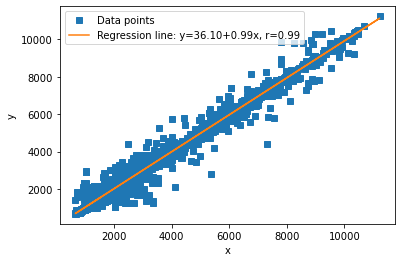

In [18]:


df_out=df_out.astype('float32')
x=df_out.Prediction[df_out.Depth==10][df_out.Pit==5]
y=df_out.Actual[df_out.Depth==10][df_out.Pit==5]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [ ]:
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.stderr)
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))
np.any(df_out.Depth==2)

In [ ]:
x=df_out.Prediction[df_out.Depth==10]
y=df_out.Actual[df_out.Depth==10]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [ ]:
import scipy.stats
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))


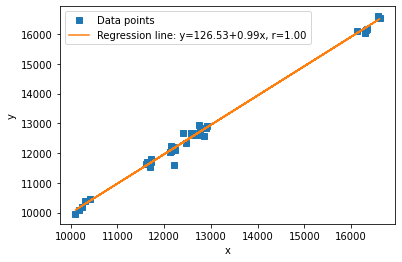

In [35]:
x=df_out.Prediction[df_out.Temp>=31.5]
y=df_out.Actual[df_out.Temp>=31.5]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [ ]:
x=df_out.Prediction[df_out.Temp<=-3]
y=df_out.Actual[df_out.Temp<=-3]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()